In [1]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [3]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
# df_large = csv_format_discrete(r"")

### chi-squared test

In [4]:
df_small

,One,Two,Three,Four,Five,Six,Seven,Eight
1,1,1,0,0,0,1,0,1
2,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,1,0
4,1,0,1,0,0,0,1,0
5,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9996,0,0,1,0,0,0,0,0
9997,1,0,1,0,0,0,1,1
9998,0,0,0,0,0,0,1,0
9999,1,0,0,0,0,0,1,0


In [5]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Pearson's Product Moment Correlation Coefficient

In [6]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [7]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

### Sorting Functions

In [8]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [9]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

### 1st order CI

In [10]:
#1st order CI
def cond_1_generate(df, rho):
    v = list(df)
    p_permutations = list(itertools.permutations(v,3))
    order_0 = create_permutations(chi2bool(df, rho)[0])
    generated = [x for x in p_permutations if x[:2] not in order_0]
    generated_0 = set(tuple(sorted(items[:2])) for items in generated)
    generate_return = [x for x in generated if x[:2] in generated_0]
    return generate_return

In [11]:
def cond_1_test(df, rho):
    chi2_data = []
    phi = cond_1_generate(df, rho)
    for i,j,k in phi:
        chi2 = chi_square(X=i, Y=j, Z=[k], data=df, significance_level=rho)
        chi2_data.append((i,j,k,chi2))
    true_list = [x for x in chi2_data if True in x]
    false_list = [x for x in chi2_data if False in x]
    return true_list, false_list

### CONDITIONAL MAIN CODE

In [12]:
def PC_(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n an integer, the stopping point of the while loop
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]])
    #x[:2] for 0th order and its permutations, so we can later remove it 
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1, p_2, p_3 = [x[:1] for x in list_permutations], [x[1:2] for x in list_permutations], [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p_3):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        #create_permutations ensures only 1 set of permutations of (X,Y) and (Y,X) and removes dupes
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list) #returns 1 set of permutations

#ON MEDIUM SIZED NETWORKS:
#1st order CI takes 2minutes to run
#2nd order CI 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

### graph

In [161]:
def Graph(df):
    G = nx.Graph()
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
#     print(G)
    return(G)

Graph with 8 nodes and 28 edges


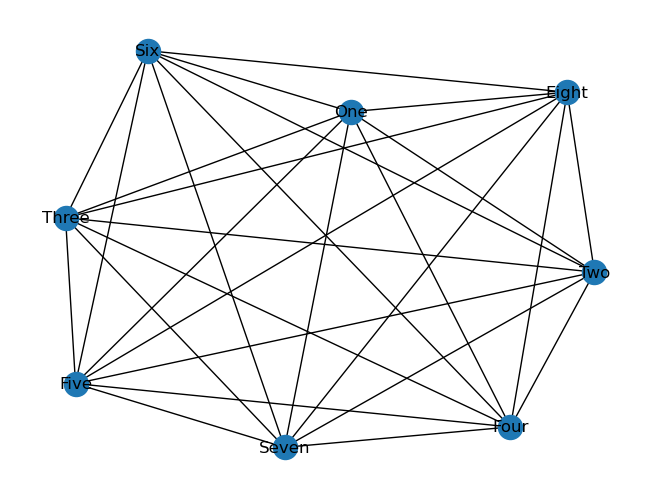

In [180]:
g = Graph(df_small)
print(g)
nx.draw(g, with_labels = True)

In [177]:
def PC_0(df, rho, G):
    '''
    finds 0th order conditional independencies (CI) between each node, if True then remove an edge 
    '''
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
    ind_0 = [x[:2] for x in chi2bool(df, rho)[0]]
    for i,j in ind_0:
        G.remove_edge(i,j)
#     print(G)
    return(G)

Graph with 8 nodes and 20 edges


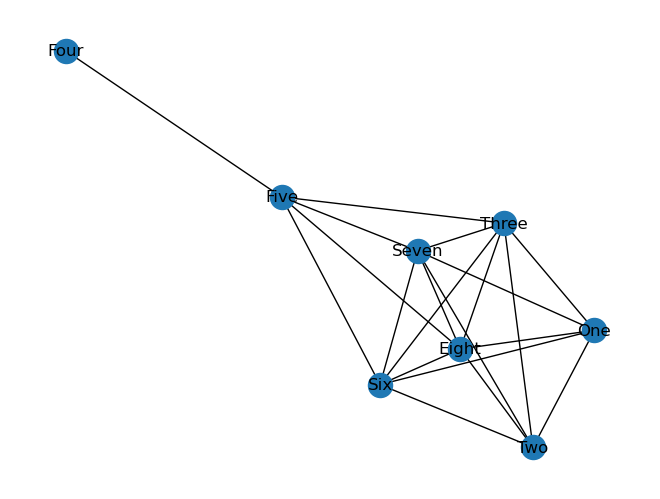

In [183]:
g_0 = PC_0(df_small, 0.05, g)
print(g_0)
nx.draw(g_0, with_labels = True)

In [217]:
false_list

[('One', 'Two'),
 ('One', 'Three'),
 ('One', 'Six'),
 ('One', 'Seven'),
 ('One', 'Eight'),
 ('Two', 'Three'),
 ('Two', 'Six'),
 ('Two', 'Seven'),
 ('Two', 'Eight'),
 ('Three', 'Five'),
 ('Three', 'Six'),
 ('Three', 'Seven'),
 ('Three', 'Eight'),
 ('Four', 'Five'),
 ('Five', 'Six'),
 ('Five', 'Seven'),
 ('Five', 'Eight'),
 ('Six', 'Seven'),
 ('Six', 'Eight'),
 ('Seven', 'Eight')]

In [231]:
def find_adjacency_XY(graph):    
    test_list = []
    graph_list = list(graph.edges)
    for i,j in graph_list:
        test_list.append((i, j, list(graph.edges(i)), list(graph.edges(j))))
    n = 0
    N = len(test_list)
    edge_XY = []
    while n < N:
        ##
        adjacent_X = []
        adjacent_Y = []
        X, Y = test_list[n][0], test_list[n][1]
        k_X, k_Y = test_list[n][2], test_list[n][3]
        edge_X = [x for x in k_X if x[1] != Y]
        edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
        for x in edge_X:
            adjacent_X.append(x[1])
        for y in edge_Y:
            adjacent_Y.append(y[1])
        adjacent_XY = adjacent_X + adjacent_Y
        len_XY = len(adjacent_XY)
        edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
        n += 1
    return edge_XY

In [230]:
find_adjacency_XY(g_0)

20


[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('One', 'Three', ['Two', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Six', ['Two', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Seven', ['Two', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('One', 'Eight', ['Two', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Two', 'Three', ['One', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Six', ['One', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Seven', ['One', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('Two', 'Eight', ['One', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Three', 'Five', ['One', 'Two', 'Six', 'Seven', 'Eight', 'Four'], 6),
 ('Three', 'Six', ['One', 'Two', 'Five', 'Seven', 'Eight'], 5),
 ('Three', 'Seven', ['One', 'Two', 'Five', 'Six', 'Eight'], 5),
 ('Three', 'Eight', ['One', 'Two', 'Five', 'Six', 'Seven'], 5),
 ('Four', 'Five', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('Five', 'Six', ['Three', 'Four', 'Seven', 'Eight', 'One', 'Two'], 6),
 ('Five', 'Seven', ['Three', 'Four', '

In [228]:
test_list = []
graph_list = list(g_0.edges)
for i,j in graph_list:
    test_list.append((i, j, list(g_0.edges(i)), list(g_0.edges(j))))
n = 0
N = len(test_list)
# print(N)
edge_XY = []
while n < N:
    ##
    adjacent_X = []
    adjacent_Y = []
    X, Y = test_list[n][0], test_list[n][1]
    k_X, k_Y = test_list[n][2], test_list[n][3]
    edge_X = [x for x in k_X if x[1] != Y]
    edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
    for x in edge_X:
        adjacent_X.append(x[1])
    for y in edge_Y:
        adjacent_Y.append(y[1])
    adjacent_XY = adjacent_X + adjacent_Y
    len_XY = len(adjacent_XY)
    edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
    n += 1
edge_XY

[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('One', 'Three', ['Two', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Six', ['Two', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Seven', ['Two', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('One', 'Eight', ['Two', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Two', 'Three', ['One', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Six', ['One', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Seven', ['One', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('Two', 'Eight', ['One', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Three', 'Five', ['One', 'Two', 'Six', 'Seven', 'Eight', 'Four'], 6),
 ('Three', 'Six', ['One', 'Two', 'Five', 'Seven', 'Eight'], 5),
 ('Three', 'Seven', ['One', 'Two', 'Five', 'Six', 'Eight'], 5),
 ('Three', 'Eight', ['One', 'Two', 'Five', 'Six', 'Seven'], 5),
 ('Four', 'Five', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('Five', 'Six', ['Three', 'Four', 'Seven', 'Eight', 'One', 'Two'], 6),
 ('Five', 'Seven', ['Three', 'Four', '

In [221]:
list(g_0.edges)

[('One', 'Two'),
 ('One', 'Three'),
 ('One', 'Six'),
 ('One', 'Seven'),
 ('One', 'Eight'),
 ('Two', 'Three'),
 ('Two', 'Six'),
 ('Two', 'Seven'),
 ('Two', 'Eight'),
 ('Three', 'Five'),
 ('Three', 'Six'),
 ('Three', 'Seven'),
 ('Three', 'Eight'),
 ('Four', 'Five'),
 ('Five', 'Six'),
 ('Five', 'Seven'),
 ('Five', 'Eight'),
 ('Six', 'Seven'),
 ('Six', 'Eight'),
 ('Seven', 'Eight')]

In [219]:
find_adjacency_XY(g_0)

20


[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4)]

In [202]:
%%time
n = 0
N = len(test_list)
output = []
edge_XY_test = []
while n < N:
    ##
    adjacent_X = []
    adjacent_Y = []
    edge_XY = []
    X, Y = test_list[n][0], test_list[n][1]
    k_X, k_Y = test_list[n][2], test_list[n][3]
    edge_X = [x for x in k_X if x[1] != Y]
    edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
    for x in edge_X:
        adjacent_X.append(x[1])
    for y in edge_Y:
        adjacent_Y.append(y[1])
    adjacent_XY = adjacent_X + adjacent_Y
    len_XY = len(adjacent_XY)
    edge_XY.append((X, Y, adjacent_XY, len_XY))
    edge_XY_test.append((X, Y, adjacent_XY, len_XY))
    print(edge_XY)
    
        ##
    chi2_list = []
    z = []
    for i in edge_XY:
        val = 2
        value = i[3]
        while val <= value:
            ncn = list(itertools.combinations(i[2], val))
            z.append(ncn)
            val += 1
    for i,j in zip(edge_XY, z):
#         print(i[0], i[1], i[2], i[3])
        n_z = 0
        n_stop = i[3]
        while n_z <=  n_stop:
            chi2 = chi_square(X=i[0], Y=i[1], Z=j[n_z], data=df_small, significance_level=0.05)
            if chi2 == True:
                chi2_list.append((i[0], i[1], j[n_z], chi2))
                break
            n_z += 1
    n += 1
# output = [x for x in output if x != []]

[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4)]
[('One', 'Three', ['Two', 'Six', 'Seven', 'Eight', 'Five'], 5)]
[('One', 'Six', ['Two', 'Three', 'Seven', 'Eight', 'Five'], 5)]
[('One', 'Seven', ['Two', 'Three', 'Six', 'Eight', 'Five'], 5)]
[('One', 'Eight', ['Two', 'Three', 'Six', 'Seven', 'Five'], 5)]
[('Two', 'Three', ['One', 'Six', 'Seven', 'Eight', 'Five'], 5)]
[('Two', 'Six', ['One', 'Three', 'Seven', 'Eight', 'Five'], 5)]
[('Two', 'Seven', ['One', 'Three', 'Six', 'Eight', 'Five'], 5)]
[('Two', 'Eight', ['One', 'Three', 'Six', 'Seven', 'Five'], 5)]
[('Three', 'Five', ['One', 'Two', 'Six', 'Seven', 'Eight', 'Four'], 6)]
[('Three', 'Six', ['One', 'Two', 'Five', 'Seven', 'Eight'], 5)]
[('Three', 'Seven', ['One', 'Two', 'Five', 'Six', 'Eight'], 5)]
[('Three', 'Eight', ['One', 'Two', 'Five', 'Six', 'Seven'], 5)]
[('Four', 'Five', ['Three', 'Six', 'Seven', 'Eight'], 4)]
[('Five', 'Six', ['Three', 'Four', 'Seven', 'Eight', 'One', 'Two'], 6)]
[('Five', 'Seven', ['Three', 'Four', '

In [203]:
edge_XY_test

[('One', 'Two', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('One', 'Three', ['Two', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Six', ['Two', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('One', 'Seven', ['Two', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('One', 'Eight', ['Two', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Two', 'Three', ['One', 'Six', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Six', ['One', 'Three', 'Seven', 'Eight', 'Five'], 5),
 ('Two', 'Seven', ['One', 'Three', 'Six', 'Eight', 'Five'], 5),
 ('Two', 'Eight', ['One', 'Three', 'Six', 'Seven', 'Five'], 5),
 ('Three', 'Five', ['One', 'Two', 'Six', 'Seven', 'Eight', 'Four'], 6),
 ('Three', 'Six', ['One', 'Two', 'Five', 'Seven', 'Eight'], 5),
 ('Three', 'Seven', ['One', 'Two', 'Five', 'Six', 'Eight'], 5),
 ('Three', 'Eight', ['One', 'Two', 'Five', 'Six', 'Seven'], 5),
 ('Four', 'Five', ['Three', 'Six', 'Seven', 'Eight'], 4),
 ('Five', 'Six', ['Three', 'Four', 'Seven', 'Eight', 'One', 'Two'], 6),
 ('Five', 'Seven', ['Three', 'Four', '

In [119]:
n, N = 0, len(test_list)
k = edge_XY_test
while n < N:
    p = (k[n][0], k[n][1], k[n][2])
    val = 1
    value = k[n][3]
    while val <= value:
        combinations = list(itertools.combinations(k[n][2], val))
        t = 0
        T = len(combinations)
        print(T)
#         print(t,T)
        while t < T:
#             chi2 = chi_square(X=k[val][0], Y=k[val][1], Z=combinations[t], data=df_small, significance_level=0.05)
#             print(chi2)
#             print(k[t][0], k[t][1])
#             print(combinations)
#             print(combinations[t])
#             print(combinations)
            t += 1
#             print(k[n][0], k[n][1])
#             print(combinations)
#             print(len(combinations))
#             print(combinations[n])
#             print('break')
#         chi2 = chi_square(X=k[n][0], k[n][1], Z=combinations[n])
        val += 1
    n += 1


4
6
4
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
6
15
20
15
6
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1
4
6
4
1
6
15
20
15
6
1
6
15
20
15
6
1
6
15
20
15
6
1
5
10
10
5
1
5
10
10
5
1
5
10
10
5
1


In [ ]:
z_0 = []
for s,t,u,v in edge_XY:
    z = list(itertools.combinations(u,2))
    z_0.append(z)
#     c2 = chi_square(X=s, Y=t, Z=list(itertools.combinations(u,2)), data=df_small, significance_level=0.05)

In [ ]:
edge_XY

### small network

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -22466.396546491495
**********
Eight<-Six,Three -4150.291729106073
Six<-Five,Two -5.611578690688475
Three<- -6901.1493808303785
Five<-Four -633.8404777927353
Four<- -527.7536882896093
One<-Three -6460.081285708176
Seven<-Six -1881.452188461728
Two<-One -1906.2162176121055
**********
bnlearn modelstring = 
[Eight|Six:Three][Six|Two:Five][Three][Five|Four][Four][One|Three][Seven|Six][Two|One]
**********
CPDAG:
Vertices: Eight,Six,Three,Five,Four,One,Seven,Two
Six->Eight
Six->Seven
Three->Eight
Three-One
Five->Six
Four-Five
One-Two
Two->Six



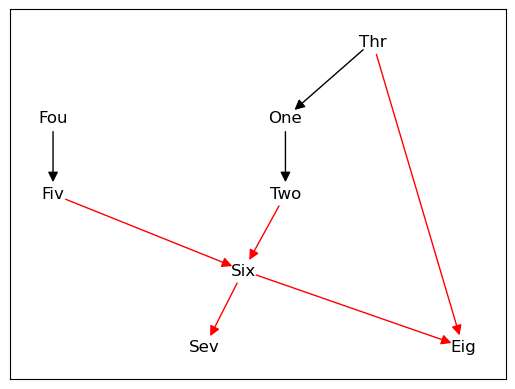

In [63]:
m = Gobnilp()
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat')